A look at GAMA single-sersic colour profiles

Code collected from BD_analysis.ipynb and plot_illustrations.py


In [81]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0*1.3, 8*1.3)
plt.rcParams['font.size'] = 18*1.3

In [82]:
import numpy as np

In [83]:
import pandas
#from galapagos_to_pandas import galapagos_to_pandas
## convert the GALAPAGOS data
#galapagos_to_pandas()
## convert the SIGMA data
#galapagos_to_pandas('/home/ppzsb1/projects/gama/qc/raw/StructureCat_SersicExp.fits',
#                    '/home/ppzsb1/quickdata/StructureCat_SersicExp.h5')

In [385]:
## read in GALAPAGOS data
## no attempt has been made to select only reliable bulges and discs
store = pandas.HDFStore('../data/GAMA_9_all_combined_gama_only_bd6.h5')
data_all = store['data'].set_index('CATAID')
print len(data_all)

51838


In [454]:
## restrict to Vulcani selection objects
data = data_all[(data_all.MAG_GALFIT_BAND_PH_R < -21.2) & (data_all.MAG_GALFIT_BAND_PH_R > -30) & (data_all.Z < 0.3)]
len(data)

11098

In [455]:
## band information
allbands = list('ugrizYJHK')
#band_wl = pandas.Series([3543,4770,6231,7625,9134,10395,12483,16313,22010], index=allbands)
normband = 'r'
bands = list('ugrizYJH')
band_labels = ['${}$'.format(i) for i in bands]
band_wl = pandas.Series([3543,4770,6231,7625,9134,10395,12483,16313], index=bands)
#normband = 'Z'
#bands = list('ugriYJHK')
#band_wl = numpy.array([3543,4770,6231,7625,10395,12483,16313,22010])

In [456]:
## extract magnitudes and use consistent column labels
mag_b = data[['MAG_GALFIT_BAND_B_{}'.format(b.upper()) for b in allbands]]
mag_d = data[['MAG_GALFIT_BAND_D_{}'.format(b.upper()) for b in allbands]]
mag_s = data[['MAG_GALFIT_BAND_{}'.format(b.upper()) for b in allbands]]
mag_b.columns = mag_d.columns = mag_s.columns = allbands
re_b = data[['RE_GALFIT_BAND_B_{}'.format(b.upper()) for b in allbands]]
re_d = data[['RE_GALFIT_BAND_D_{}'.format(b.upper()) for b in allbands]]
re_s = data[['RE_GALFIT_BAND_{}'.format(b.upper()) for b in allbands]]
re_b.columns = re_d.columns = re_s.columns = allbands
n_b = data[['N_GALFIT_BAND_B_{}'.format(b.upper()) for b in allbands]]
n_d = data[['N_GALFIT_BAND_D_{}'.format(b.upper()) for b in allbands]]
n_s = data[['N_GALFIT_BAND_{}'.format(b.upper()) for b in allbands]]
n_b.columns = n_d.columns = n_s.columns = allbands

In [457]:
from scipy.special import gamma, gammaincinv
from numpy import log, log10, exp, power, pi

class Sersic:
    # currently doesn't handle uncertainties
    def __init__(self, mag, re, n, ar=1.0, pa=0.0,
                 mag_err=None, re_err=None, n_err=None, ar_err=None, pa_err=None, xc_err=None, yc_err=None):
        self.mag = mag
        self.re = re
        self.n = n
        self.ar = ar
        self.pa = pa
        self.mag_err = mag_err
        self.re_err = re_err
        self.n_err = n_err
        self.ar_err = ar_err
        self.pa_err = pa_err
    def __call__(self, r):
        return self.mu_r(r)
    def mu_r(self, r):
        # Returns the surface brightess at specified major axis radius,
        # within annular ellipses corresponding to the shape of each component individualy 
        # Taking, e.g. colours, this currently assumes major axes of components align
        # to be more generally correct need to account for AR, PA, XC, YC,
        # and either select specific vector, or properly compute azimuthal average
        mag = self.mag
        re = self.re
        n = self.n
        bn = self.bn()
        mue = mag + 5.0*log10(re) + 2.5*log10(2.0*pi*n*gamma(2.0*n)*exp(bn)/power(bn, 2.0*n))
        mu = mue + 2.5 * bn / log(10) * (power(r/re, 1.0/n) - 1.0)
        return mu
    def bn(self):
        return gammaincinv(2.0*self.n, 0.5)
    # These need testing
    def I_el(self, r_m, ar_m, pa_m=0):
        return quad(self.I_el_theta, 0, 2*pi, args=(r_m, ar_m, pa_m))[0] / (2*pi)
    def mu_el(self, r_m, ar_m, pa_m=0):
        return -2.5*numpy.log10(self.I_el(r_m, ar_m, pa_m))
    def mu_el_theta(self, theta, r_m, ar_m, pa_m=0):
        x = r_m * numpy.cos(theta - pa_m)
        y = ar_m * r_m * numpy.sin(theta - pa_m)
        r_c = numpy.sqrt(x**2 + self.ar**2 * y**2)
        return self.mu_r(r_c)
    def I_el_theta(self, theta, r_m, ar_m, pa_m=0):
        return 10**(-0.4*self.mu_el_theta(theta, r_m, ar_m, pa_m))

In [458]:
def make_funcs(ids):
    func = {}
    for i in ids:
        func[i] = {}
        remax = 0
        for band in bands:
            func[i][band] = Sersic(mag_s[band].iloc[i], re_s[band].iloc[i]/re_s[normband].iloc[i], n_s[band].iloc[i])
    return func

In [459]:
def plot_colour_profile(prof, band1='g', band2='r', *args, **kwargs):
    lograd = np.arange(-2, log10(5)+0.1, 0.1)
    rad = 10**lograd
    b1 = prof[band1](rad)
    b2 = prof[band2](rad)
    col = b1 - b2
    plt.plot(rad, col, *args, **kwargs)
    plt.semilogx()
    plt.gca().set_xticks([0.01, 0.03, 0.1, 0.3, 1.0, 3.0])
    plt.gca().xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.xlim((0.01, 5))
    plt.ylim((-2, 5))

In [460]:
def colour_gradient(prof, band1='g', band2='r', rad1=0.1, rad2=1.0):
    rad = [rad1, rad2]
    b1 = prof[band1](rad)
    b2 = prof[band2](rad)
    col = b1 - b2
    grad = col[1] - col[0]
    return grad

In [461]:
f = make_funcs(np.arange(len(data)))

In [462]:
def plot_colour_gradient_distribs(profs):
    fig, ax = plt.subplots(len(bands[2:]), 1, sharex=True, sharey=True)
    for i, b in enumerate(bands[2:]):
        g = np.array([colour_gradient(profs[id], 'g', b) for id in profs.keys()])
        g = g[~np.isnan(g)].clip(-4, 4)
        label = '${}:\quad \mu={:.2f}\quad \sigma={:.2f}$'.format(b, g.mean(), g.std())
        ax[i].hist(g, range=(-4, 4), bins=100, histtype='step', label=label, normed=True)
        ax[i].legend(fontsize='small',loc='upper left')
    plt.xlim((-3, 2))
    ax[0].set_yticks((0.0, 1.0, 2.0))
    ax[-1].set_xlabel('$\Delta(g-x)$')
    fig.text(0.05, 0.5, 'norm. freq.', va='center', rotation='vertical')
    plt.subplots_adjust(hspace=0)

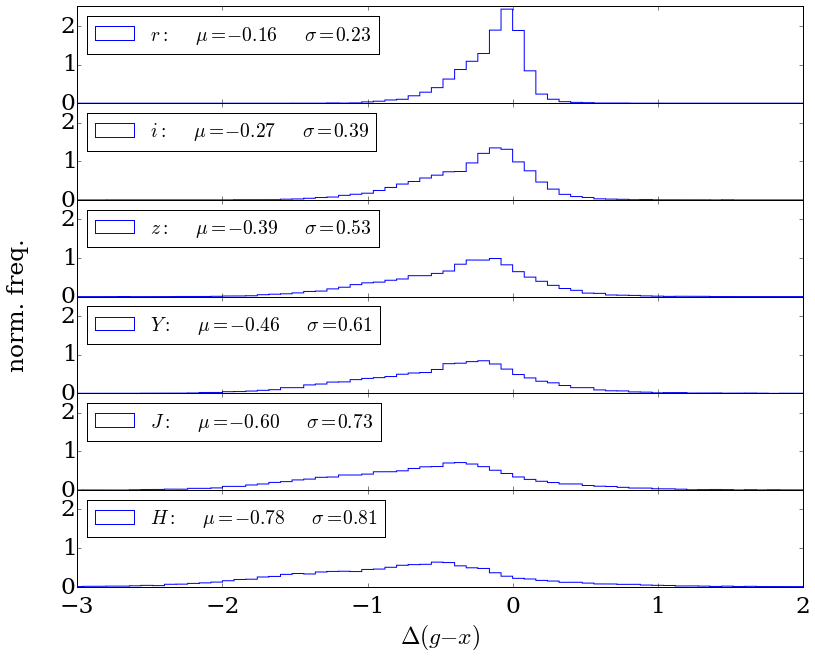

In [463]:
plot_colour_gradient_distribs(f)

In [464]:
f_high_n = {}
for k in f.keys():
    if n_s.r.iloc[k] > 2.5:
        f_high_n[k] = f[k]

In [465]:
f_low_n = {}
for k in f.keys():
    if n_s.r.iloc[k] < 2.5:
        f_low_n[k] = f[k]

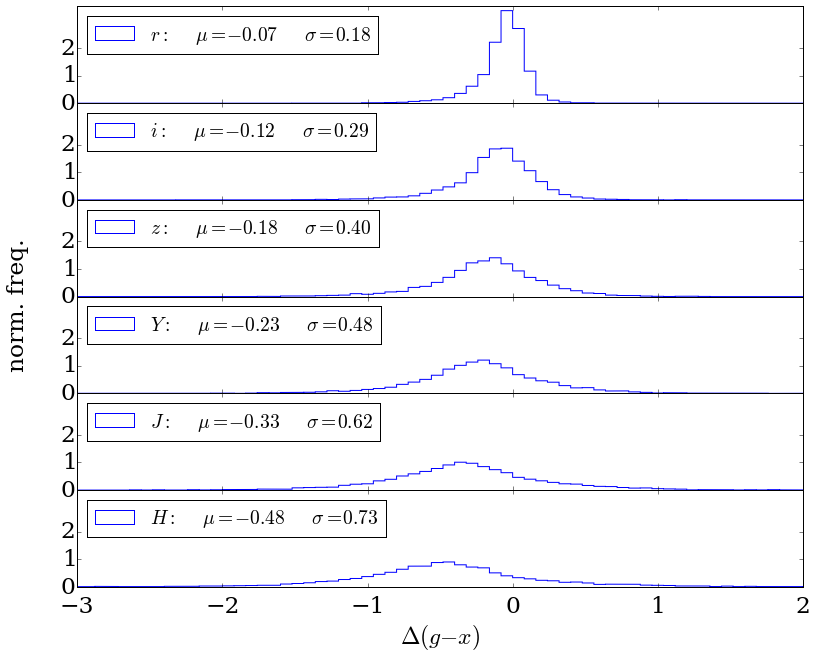

In [466]:
plot_colour_gradient_distribs(f_high_n)

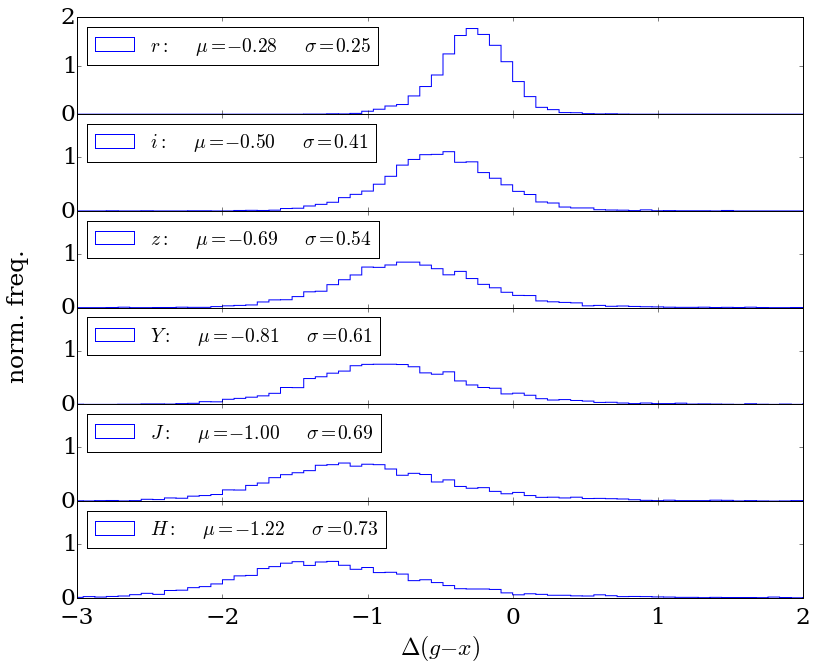

In [467]:
plot_colour_gradient_distribs(f_low_n)

In [475]:
ids = np.random.choice(len(data), 2000, replace=False)

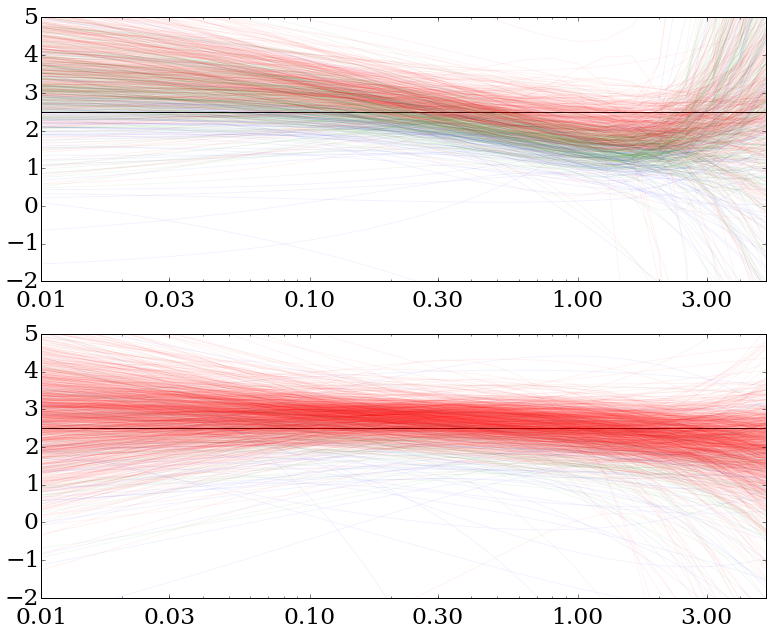

In [477]:
coltot = (mag_s.u - mag_s.r)

plt.subplot(211)

for id in ids:
    if n_s.r.iloc[id] > 2.5:
        continue
    if coltot.iloc[id] > 2.1:
        c = 'r'
    elif coltot.iloc[id] > 1.6:
        c = 'g'
    else:
        c = 'b'
    plot_colour_profile(f[id], 'g', 'J', c=c, alpha=0.05)
    plt.hlines([2.5], 0.01, 5.0)
    
plt.subplot(212)
for id in ids:
    if n_s.r.iloc[id] < 2.5:
        continue
    if coltot.iloc[id] > 2.1:
        c = 'r'
    elif coltot.iloc[id] > 1.6:
        c = 'g'
    else:
        c = 'b'
    plot_colour_profile(f[id], 'g', 'J', c=c, alpha=0.05)
    plt.hlines([2.5], 0.01, 5.0)

In [470]:
def colour_at_rad(profs, rad=1.0, band1='g', band2='r'):
    return np.array([f[id][band1](rad) - f[id][band2](rad) for id in f.keys()])

In [471]:
def colour_at_rad_hist(profs, band1='g', band2='r'):
    col1re = colour_at_rad(profs, 1.0, band1, band2)
    col0p1re = colour_at_rad(profs, 0.1, band1, band2)
    col2re = colour_at_rad(profs, 2.0, band1, band2)
    col3re = colour_at_rad(profs, 3.0, band1, band2)
    coltot = (mag_s[band1] - mag_s[band2]).values
    plt.hist((coltot, col0p1re, col1re, col2re, col3re), range=(-1, 4), bins=50, histtype='step',
             label=('total', '0.1Re', '1Re', '2Re', '3Re'), normed=True)
    plt.legend()
    plt.xlabel('${}-{}$'.format(band1, band2))
    plt.ylabel('norm. freq.')

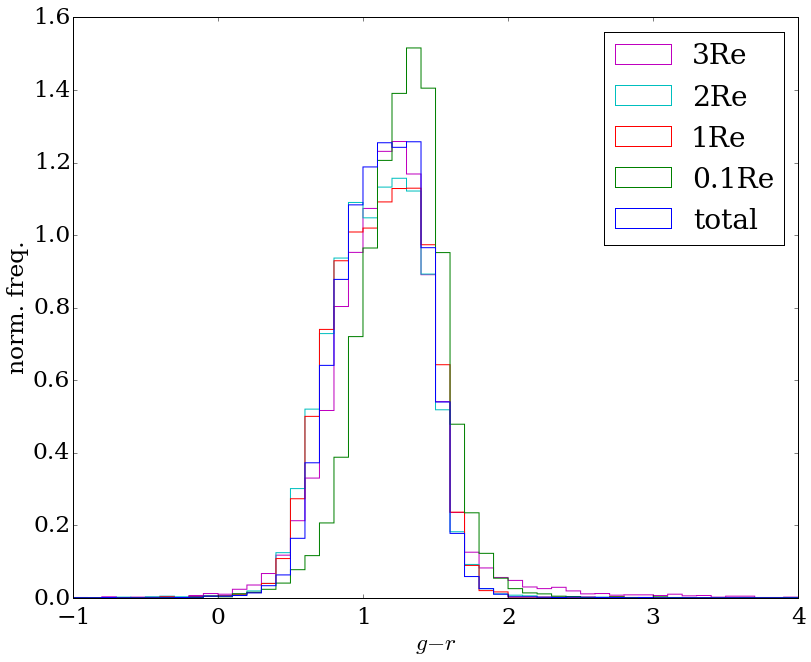

In [472]:
colour_at_rad_hist(f, 'g', 'r')